In [72]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor 
warnings.filterwarnings("ignore")

In [73]:
seinfeld = pd.read_csv('seinfeld episode rankings.csv')

In [74]:
seinfeld

,Title,Plot,Quotability/cultural impact,Laughs,Total score,IMDb rating,IMDb rank,Notes,Season,episode
0,The Seinfeld Chronicles 1:1,4.0,7.0,7.0,8.521739,7.6,77.0,2nd button joke,1.0,1.0
1,Male Unbonding 1:2,3.0,6.5,2.0,1.695652,7.3,84.0,Kramer's pizza idea,1.0,2.0
2,The Stakeout 1:3,4.0,7.0,9.0,10.956522,7.7,73.0,Art Vandelay first appearance,1.0,3.0
3,The Robbery 1:4,3.0,3.5,5.5,2.510870,7.6,77.0,NaN,1.0,4.0
4,The Stock Tip 1:5,3.0,3.0,6.5,2.543478,7.5,79.0,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
177,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


In [75]:
seinfeld.columns=['title','plot','quotability','laughs','total_score','imdb_rating','imdb_rank','notes','season','episode']

In [76]:
seinfeld=seinfeld[seinfeld.laughs>0]

In [77]:
seinfeld.sort_values('total_score',ascending=False)

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
77,The Marine Biologist,5.0,9.0,52.0,101.739130,9.2,4.0,NaN,5.0,14.0
83,The Hamptons,5.0,9.0,48.0,93.913043,8.9,5.0,"""Shrinkage""",5.0,20.0
50,The Contest 4:11,5.0,10.0,31.0,67.391304,9.6,1.0,first appearance of Estelle.,4.0,11.0
74,The Conversion,5.0,9.0,30.0,58.695652,8.1,53.0,NaN,5.0,11.0
84,The Opposite,4.0,9.0,31.5,49.304348,9.6,1.0,NaN,5.0,21.0
...,...,...,...,...,...,...,...,...,...,...
20,The Dog 3:4,3.0,3.0,7.0,2.739130,7.3,84.0,NaN,3.0,4.0
14,The Baby Shower 2:10,3.0,3.0,7.0,2.739130,7.5,79.0,NaN,2.0,10.0
4,The Stock Tip 1:5,3.0,3.0,6.5,2.543478,7.5,79.0,NaN,1.0,5.0
3,The Robbery 1:4,3.0,3.5,5.5,2.510870,7.6,77.0,NaN,1.0,4.0


In [78]:
scripts = pd.read_csv('seinfeld_data/scripts.csv')

In [79]:
episodes = pd.read_csv('seinfeld_data/episode_info.csv')

In [80]:
episodes = episodes.drop(columns='Unnamed: 0')

In [81]:
episodes.Title = episodes.Title.astype(str)

In [82]:
episodes.Title = episodes.Title.str.lower().str.replace(' ','_').str.replace(',','')

In [83]:
scripts = scripts.drop(columns='Unnamed: 0')

In [84]:
scripts[0:211].SEID = 'S01E00'
scripts[0:211].EpisodeNo = 0.0

In [85]:
episodes

,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID
0,1.0,1.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E01
1,1.0,1.0,the_stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01
2,1.0,2.0,the_robbery,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02
3,1.0,3.0,male_unbonding,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03
4,1.0,4.0,the_stock_tip,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04
...,...,...,...,...,...,...,...
169,9.0,17.0,the_bookstore,"April 9, 1998",Spike Feresten,Andy Ackerman,S09E17
170,9.0,18.0,the_frogger,"April 23, 1998","Gregg Kavet, Andy Robin",Andy Ackerman,S09E18
171,9.0,19.0,the_maid,"April 30, 1998","Alec Berg, David Mandel, Jeff Schaffer",Andy Ackerman,S09E19
172,9.0,20.0,the_puerto_rican_day,"May 7, 1998","Alec Berg, Jennifer Crittenden, Spike Feresten...",Andy Ackerman,S09E20


In [86]:
episodes.SEID[0] = 'S01E00'
episodes.EpisodeNo[0] = 0.0

In [87]:
scripts

,Character,Dialogue,EpisodeNo,SEID,Season
0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
2,GEORGE,Are you through?,0.0,S01E00,1.0
3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0
...,...,...,...,...,...
54611,JERRY,Grand theft auto - don't steal any of my jokes.,23.0,S09E23,9.0
54612,PRISONER 3,You suck - I'm gonna cut you.,23.0,S09E23,9.0
54613,JERRY,"Hey, I don't come down to where you work, and ...",23.0,S09E23,9.0
54614,GUARD,"Alright, Seinfeld, that's it. Let's go. Come on.",23.0,S09E23,9.0


In [88]:
scripts[scripts.SEID=='S01E00']

,Character,Dialogue,EpisodeNo,SEID,Season
0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
2,GEORGE,Are you through?,0.0,S01E00,1.0
3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0
...,...,...,...,...,...
206,LAURA,"Yeah, yeah, hes a great guy...",0.0,S01E00,1.0
207,JERRY,Yeah.,0.0,S01E00,1.0
208,LAURA,"Youd really like him, you know, I cant wait to...",0.0,S01E00,1.0
209,JERRY,Me too!,0.0,S01E00,1.0


In [89]:
scripts.Character=scripts.Character.str.replace(r"\(.*\)","")

In [90]:
line_count=scripts.Character.value_counts().head(475)

In [91]:
scripts.Character.str.strip().value_counts().head(10)

JERRY       14905
GEORGE       9781
ELAINE       8073
KRAMER       6723
NEWMAN        649
MORTY         507
HELEN         474
FRANK         438
SUSAN         382
[Setting      293
Name: Character, dtype: int64

In [92]:
episodes["SEID"] = episodes.SEID.astype(str)
scripts["SEID"] = scripts.SEID.astype(str)

In [93]:
scripts[scripts.SEID=='S01E04']

,Character,Dialogue,EpisodeNo,SEID,Season
1078,JERRY,Went out to dinner the other night. Check came...,4.0,S01E04,1.0
1079,JERRY,I think Superman probably has a very good sens...,4.0,S01E04,1.0
1080,GEORGE,I never heard him say anything really funny.,4.0,S01E04,1.0
1081,JERRY,"But its common sense. Hes got super strength, ...",4.0,S01E04,1.0
1082,GEORGE,"You would think that, but either youre born wi...",4.0,S01E04,1.0
...,...,...,...,...,...
1303,JERRY,We went over that.,4.0,S01E04,1.0
1304,GEORGE,Pst. (moves in close with Elaine and Jerry) Wi...,4.0,S01E04,1.0
1305,JERRY,A robot butcher?,4.0,S01E04,1.0
1306,GEORGE,"Shhhhh. If you want to get in, theres very lit...",4.0,S01E04,1.0


In [94]:
pd.merge(episodes, right=scripts, on='SEID')

,Season_x,EpisodeNo_x,Title,AirDate,Writers,Director,SEID,Character,Dialogue,EpisodeNo_y,Season_y
0,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,JERRY,Do you know what this is all about? Do you kno...,0.0,1.0
1,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,1.0
2,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,GEORGE,Are you through?,0.0,1.0
3,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,JERRY,"You do of course try on, when you buy?",0.0,1.0
4,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
54611,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,JERRY,Grand theft auto - don't steal any of my jokes.,23.0,9.0
54612,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,PRISONER 3,You suck - I'm gonna cut you.,23.0,9.0
54613,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,JERRY,"Hey, I don't come down to where you work, and ...",23.0,9.0
54614,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,GUARD,"Alright, Seinfeld, that's it. Let's go. Come on.",23.0,9.0


In [95]:
seinfeld.title[0] = 'good_news_bad_news'

In [96]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,77.0,2nd button joke,1.0,1.0
1,Male Unbonding 1:2,3.0,6.5,2.0,1.695652,7.3,84.0,Kramer's pizza idea,1.0,2.0
2,The Stakeout 1:3,4.0,7.0,9.0,10.956522,7.7,73.0,Art Vandelay first appearance,1.0,3.0
3,The Robbery 1:4,3.0,3.5,5.5,2.510870,7.6,77.0,NaN,1.0,4.0
4,The Stock Tip 1:5,3.0,3.0,6.5,2.543478,7.5,79.0,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
80,The Wife,4.0,8.0,23.0,32.000000,8.0,61.0,NaN,5.0,17.0
81,The Raincoats,3.0,8.0,38.0,19.826087,8.3,35.0,NaN,5.0,18.0
82,The Fire,4.0,7.0,27.0,32.869565,8.5,20.0,"""Jon Favreau as eric the clown""",5.0,19.0
83,The Hamptons,5.0,9.0,48.0,93.913043,8.9,5.0,"""Shrinkage""",5.0,20.0


In [97]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,77.0,2nd button joke,1.0,1.0
1,Male Unbonding 1:2,3.0,6.5,2.0,1.695652,7.3,84.0,Kramer's pizza idea,1.0,2.0
2,The Stakeout 1:3,4.0,7.0,9.0,10.956522,7.7,73.0,Art Vandelay first appearance,1.0,3.0
3,The Robbery 1:4,3.0,3.5,5.5,2.510870,7.6,77.0,NaN,1.0,4.0
4,The Stock Tip 1:5,3.0,3.0,6.5,2.543478,7.5,79.0,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
80,The Wife,4.0,8.0,23.0,32.000000,8.0,61.0,NaN,5.0,17.0
81,The Raincoats,3.0,8.0,38.0,19.826087,8.3,35.0,NaN,5.0,18.0
82,The Fire,4.0,7.0,27.0,32.869565,8.5,20.0,"""Jon Favreau as eric the clown""",5.0,19.0
83,The Hamptons,5.0,9.0,48.0,93.913043,8.9,5.0,"""Shrinkage""",5.0,20.0


In [98]:
episodes.columns = episodes.columns.str.lower()


In [99]:
seinfeld.title = seinfeld.title.str.replace(r"\d:\d*","").str.strip().str.replace(' ','_').str.lower()

In [100]:
seinfeld[seinfeld.title=="the_cafe"]

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
23,the_cafe,4.0,6.0,9.5,9.913043,8.4,23.0,Babu’s first appearance,3.0,7.0


In [101]:
episodes[episodes.title=='the_cafe']

,season,episodeno,title,airdate,writers,director,seid
23,3.0,7.0,the_cafe,"November 6, 1991",Tom Leopold,Tom Cherones,S03E07


In [147]:
episodes.title.to_csv('titles.csv')

In [103]:
seinfeld=pd.merge(seinfeld, right = episodes, on='title')

In [104]:
seinfeld.sort_values('total_score',ascending=True).head(10)

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,84.0,Kramer's pizza idea,1.0,2.0,1.0,3.0,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,77.0,NaN,1.0,4.0,1.0,2.0,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,79.0,NaN,1.0,5.0,1.0,4.0,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04
20,the_dog,3.0,3.0,7.0,2.739130,7.3,84.0,NaN,3.0,4.0,3.0,4.0,"October 9, 1991",Larry David,Tom Cherones,S03E04
14,the_baby_shower,3.0,3.0,7.0,2.739130,7.5,79.0,NaN,2.0,10.0,2.0,10.0,"May 16, 1991",Larry Charles,Tom Cherones,S02E10
18,the_truth,3.0,3.0,7.5,2.934783,7.8,72.0,NaN,3.0,2.0,3.0,2.0,"September 25, 1991",Elaine Pope,David Steinberg,S03E02
13,the_deal,2.0,3.0,12.0,3.130435,8.3,35.0,NaN,2.0,9.0,2.0,9.0,"May 2, 1991",Larry Charles,Tom Cherones,S02E09
12,the_heart_attack,2.0,5.0,10.0,4.347826,7.9,68.0,NaN,2.0,8.0,2.0,8.0,"April 25, 1991",Larry Charles,Tom Cherones,S02E08
10,the_statue,3.0,3.0,12.5,4.891304,8.0,61.0,NaN,2.0,6.0,2.0,6.0,"April 11, 1991",Larry David,Tom Cherones,S02E06
5,the_ex-girlfriend,3.0,5.0,7.5,4.891304,7.7,73.0,NaN,2.0,1.0,2.0,1.0,"January 16, 1991","Larry David, Jerry Seinfeld",Tom Cherones,S02E01


In [105]:
seinfeld.director = seinfeld.director.replace('David&nbsp; Steinberg','David Steinberg')

In [106]:
seinfeld.director.value_counts()

Tom Cherones       80
David Steinberg     2
Art Wolff           1
Joshua White        1
Jason Alexander     1
Name: director, dtype: int64

In [107]:
scripts.Character = scripts.Character.str.strip()
scripts.Character = scripts.Character.replace(r'babu.*|BABU.*','BABU')

In [108]:
scripts.Character.nunique()

1214

In [109]:
scripts=scripts[~scripts.Character.str.contains(r'\(\*|[a-z]|http')]

In [110]:
#scripts = scripts.drop(index=scripts[(scripts.Character==r'http')|(scripts.Dialogue.isnull())].index.tolist())
grouped_scripts=scripts.groupby('SEID')

In [111]:
for key, item in grouped_scripts:
    print(grouped_scripts.get_group(key), "\n\n")

    Character                                           Dialogue  EpisodeNo  \
0       JERRY  Do you know what this is all about? Do you kno...        0.0   
1       JERRY  (pointing at Georges shirt) See, to me, that b...        0.0   
2      GEORGE                                   Are you through?        0.0   
3       JERRY             You do of course try on, when you buy?        0.0   
4      GEORGE  Yes, it was purple, I liked it, I dont actuall...        0.0   
..        ...                                                ...        ...   
206     LAURA                     Yeah, yeah, hes a great guy...        0.0   
207     JERRY                                              Yeah.        0.0   
208     LAURA  Youd really like him, you know, I cant wait to...        0.0   
209     JERRY                                            Me too!        0.0   
210     JERRY  I swear, I have absolutely no idea what women ...        0.0   

       SEID  Season  
0    S01E00     1.0  
1    S0

[331 rows x 5 columns] 


      Character                                           Dialogue  EpisodeNo  \
27272     JERRY  I've never been able to figure out why they ma...        6.0   
27273     JERRY  I cannot believe Lindsay's still seeing you af...        6.0   
27274    GEORGE           I think she finds my stupidity charming.        6.0   
27275     JERRY                                      As we all do.        6.0   
27276    GEORGE  Yeah, anyway, she's uh, having some kind of a ...        6.0   
...         ...                                                ...        ...   
27550     KATYA  He'll be all right. I must go and be with Mish...        6.0   
27551     JERRY                                       Oh, why not?        6.0   
27552     KATYA  It has been three days since our night togethe...        6.0   
27553     JERRY                                            Really?        6.0   
27554     KATYA  In my country, they speak of a man so virile, ...        6.0   

 

In [112]:
seinfeld.writers.value_counts()

Larry David                                               21
Larry Charles                                             15
Larry David, Jerry Seinfeld                               12
Peter Mehlman                                              8
Tom Gammill, Max Pross                                     3
Bruce Kirschbaum                                           2
Tom Leopold                                                2
Larry David and Larry Levin                                2
Larry David, Larry Charles                                 2
Andy Robin                                                 2
Peter Mehlman, Carol Leifer                                1
Tom Gammill, Max Pross and Larry David, Jerry Seinfeld     1
Ron Hague, Charlie Rubin                                   1
Carol Leifer                                               1
Lawrence H. Levy, Buck Dancer (Larry David pseudonym)      1
Larry David, Peter Mehlman                                 1
Larry David and Greg Dan

In [113]:
scripts = scripts.drop(index=scripts[scripts.Character=='http'].index.tolist())

In [114]:
for Character, Dialogue in grouped_scripts:
    #print(f'{SEID}')
    print('--------')
    print(f'{Character}: {Dialogue}')

--------
S01E00:     Character                                           Dialogue  EpisodeNo  \
0       JERRY  Do you know what this is all about? Do you kno...        0.0   
1       JERRY  (pointing at Georges shirt) See, to me, that b...        0.0   
2      GEORGE                                   Are you through?        0.0   
3       JERRY             You do of course try on, when you buy?        0.0   
4      GEORGE  Yes, it was purple, I liked it, I dont actuall...        0.0   
..        ...                                                ...        ...   
206     LAURA                     Yeah, yeah, hes a great guy...        0.0   
207     JERRY                                              Yeah.        0.0   
208     LAURA  Youd really like him, you know, I cant wait to...        0.0   
209     JERRY                                            Me too!        0.0   
210     JERRY  I swear, I have absolutely no idea what women ...        0.0   

       SEID  Season  
0    S01E00 

[314 rows x 5 columns]
--------
S06E12:       Character                                           Dialogue  EpisodeNo  \
29173     JERRY               You sure you don't want the tickets?       12.0   
29174    GEORGE                                         No thanks.       12.0   
29175     JERRY  I can't believe I'm having trouble getting rid...       12.0   
29176    GEORGE  I'm telling you, skip the Drake's wedding, go ...       12.0   
29177     JERRY    I can't, the Drake put me in the wedding party.       12.0   
...         ...                                                ...        ...   
29501     SCOTT                                        Oh really?!       12.0   
29502    NEWMAN  Great streak of luck I'm having. First, Kramer...       12.0   
29503     JERRY                         Can you move over at all?!       12.0   
29504    NEWMAN  And then, just as I'm about to go, these boxes...       12.0   
29505     JERRY              An inch! Can you move over an inch?!?   

In [115]:
import dask.dataframe as dd

In [116]:
scripts_dd=dd.from_pandas(scripts,npartitions=54615)

In [117]:
scripts_dd

,Character,Dialogue,EpisodeNo,SEID,Season
npartitions=53961,,,,,
0,object,object,float64,object,float64
1,...,...,...,...,...
...,...,...,...,...,...
54614,...,...,...,...,...
54615,...,...,...,...,...


In [118]:
seinfeld_prepped=seinfeld.drop(columns=['season_x','episode','notes','title','seid','airdate'])

In [119]:
#seinfeld_prepped.airdate=pd.to_datetime(seinfeld_prepped.airdate)
#seinfeld_prepped = seinfeld_prepped.set_index('airdate').sort_values(by='airdate')

In [120]:
seinfeld_prepped = pd.get_dummies(seinfeld_prepped, columns=['writers','director'], drop_first=True)

In [121]:
train=seinfeld_prepped[seinfeld_prepped.season_y<4]
validate=seinfeld_prepped[seinfeld_prepped.season_y>3]

In [122]:
train

,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,season_y,episodeno,writers_Andy Robin,writers_Bruce Kirschbaum,...,"writers_Peter Mehlman, Carol Leifer","writers_Ron Hague, Charlie Rubin","writers_Steve Skrovan, Bill Masters, Jon Hayman","writers_Tom Gammill, Max Pross","writers_Tom Gammill, Max Pross and Larry David, Jerry Seinfeld",writers_Tom Leopold,director_David Steinberg,director_Jason Alexander,director_Joshua White,director_Tom Cherones
0,4.0,7.0,7.0,8.521739,7.6,77.0,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,6.5,2.0,1.695652,7.3,84.0,1.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4.0,7.0,9.0,10.956522,7.7,73.0,1.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3.0,3.5,5.5,2.510870,7.6,77.0,1.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3.0,3.0,6.5,2.543478,7.5,79.0,1.0,4.0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,3.0,5.0,7.5,4.891304,7.7,73.0,2.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,4.0,5.0,8.0,6.956522,7.9,68.0,2.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,5.0,6.0,8.5,11.086957,8.3,35.0,2.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,4.0,3.0,13.5,7.043478,8.4,23.0,2.0,4.0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,2.0,7.0,9.5,5.782609,7.9,68.0,2.0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [123]:
def get_script():
    for i in seinfeld.seid.to_list():
        for episode in scripts.SEID.to_list():
            script=f'TITLE: {i}\n'
            if str(scripts.SEID) == str(i):
                script += f'{scripts.Character}: {scripts.Dialogue}'
            else:
                continue
            return(script)

In [124]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,77.0,2nd button joke,1.0,1.0,1.0,0.0,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,84.0,Kramer's pizza idea,1.0,2.0,1.0,3.0,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,73.0,Art Vandelay first appearance,1.0,3.0,1.0,1.0,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,77.0,NaN,1.0,4.0,1.0,2.0,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,79.0,NaN,1.0,5.0,1.0,4.0,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,the_wife,4.0,8.0,23.0,32.000000,8.0,61.0,NaN,5.0,17.0,5.0,17.0,"March 17, 1994",Peter Mehlman,Tom Cherones,S05E17
81,the_raincoats,3.0,8.0,38.0,19.826087,8.3,35.0,NaN,5.0,18.0,5.0,18.0,April 28 1994,"Tom Gammill, Max Pross and Larry David, Jerry ...",Tom Cherones,S05E18
82,the_fire,4.0,7.0,27.0,32.869565,8.5,20.0,"""Jon Favreau as eric the clown""",5.0,19.0,5.0,20.0,"May 5, 1994",Larry Charles,Tom Cherones,S05E20
83,the_hamptons,5.0,9.0,48.0,93.913043,8.9,5.0,"""Shrinkage""",5.0,20.0,5.0,21.0,"May 12, 1994","Peter Mehlman, Carol Leifer",Tom Cherones,S05E21


In [125]:
start = scripts.index[scripts.SEID=='S01E00'][0]
end = scripts.index[scripts.SEID=='S01E00'][-1] +1

In [126]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,77.0,2nd button joke,1.0,1.0,1.0,0.0,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,84.0,Kramer's pizza idea,1.0,2.0,1.0,3.0,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,73.0,Art Vandelay first appearance,1.0,3.0,1.0,1.0,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,77.0,NaN,1.0,4.0,1.0,2.0,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,79.0,NaN,1.0,5.0,1.0,4.0,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,the_wife,4.0,8.0,23.0,32.000000,8.0,61.0,NaN,5.0,17.0,5.0,17.0,"March 17, 1994",Peter Mehlman,Tom Cherones,S05E17
81,the_raincoats,3.0,8.0,38.0,19.826087,8.3,35.0,NaN,5.0,18.0,5.0,18.0,April 28 1994,"Tom Gammill, Max Pross and Larry David, Jerry ...",Tom Cherones,S05E18
82,the_fire,4.0,7.0,27.0,32.869565,8.5,20.0,"""Jon Favreau as eric the clown""",5.0,19.0,5.0,20.0,"May 5, 1994",Larry Charles,Tom Cherones,S05E20
83,the_hamptons,5.0,9.0,48.0,93.913043,8.9,5.0,"""Shrinkage""",5.0,20.0,5.0,21.0,"May 12, 1994","Peter Mehlman, Carol Leifer",Tom Cherones,S05E21


In [127]:
train

,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,season_y,episodeno,writers_Andy Robin,writers_Bruce Kirschbaum,...,"writers_Peter Mehlman, Carol Leifer","writers_Ron Hague, Charlie Rubin","writers_Steve Skrovan, Bill Masters, Jon Hayman","writers_Tom Gammill, Max Pross","writers_Tom Gammill, Max Pross and Larry David, Jerry Seinfeld",writers_Tom Leopold,director_David Steinberg,director_Jason Alexander,director_Joshua White,director_Tom Cherones
0,4.0,7.0,7.0,8.521739,7.6,77.0,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,6.5,2.0,1.695652,7.3,84.0,1.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4.0,7.0,9.0,10.956522,7.7,73.0,1.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3.0,3.5,5.5,2.510870,7.6,77.0,1.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3.0,3.0,6.5,2.543478,7.5,79.0,1.0,4.0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,3.0,5.0,7.5,4.891304,7.7,73.0,2.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,4.0,5.0,8.0,6.956522,7.9,68.0,2.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,5.0,6.0,8.5,11.086957,8.3,35.0,2.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,4.0,3.0,13.5,7.043478,8.4,23.0,2.0,4.0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,2.0,7.0,9.5,5.782609,7.9,68.0,2.0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [128]:
x_train = train.drop(columns=['plot','quotability','laughs','total_score'])
y_train = train.total_score
x_validate = validate.drop(columns=['plot','quotability','laughs','total_score'])
y_validate = validate.total_score

In [129]:
regr = MLPRegressor( max_iter=1500).fit(x_train, y_train)

In [130]:
predictions=pd.DataFrame(regr.predict(x_validate),columns=['predict'])
regr.score(x_validate,y_validate)

-0.34311017673515565

In [131]:
y_validate=pd.concat([y_validate.reset_index(),predictions],axis=1)

<AxesSubplot:>

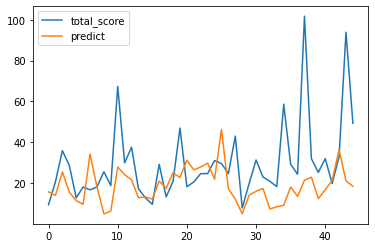

In [137]:
y_validate.drop(columns='index').plot()
#y_train.plot()

<AxesSubplot:>

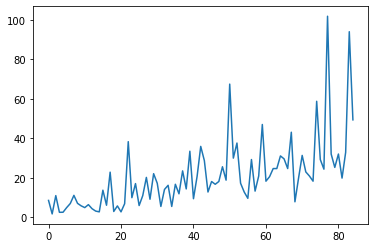

In [133]:
seinfeld.total_score.plot()

In [134]:
x = seinfeld_prepped.drop(columns=['plot','quotability','laughs','total_score'])
y = seinfeld_prepped.total_score
regr = MLPRegressor( max_iter=1500).fit(x,y)
predictions=pd.DataFrame(regr.predict(x),columns=['predict'])
y=pd.concat([y,predictions],axis=1)

<AxesSubplot:>

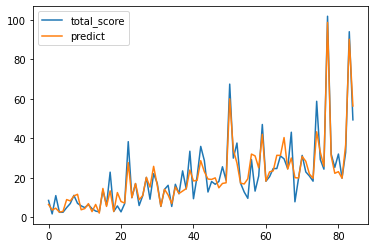

In [135]:
y.plot()

In [148]:
seinfeld_prepped.corr()

,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,season_y,episodeno,writers_Andy Robin,writers_Bruce Kirschbaum,...,"writers_Peter Mehlman, Carol Leifer","writers_Ron Hague, Charlie Rubin","writers_Steve Skrovan, Bill Masters, Jon Hayman","writers_Tom Gammill, Max Pross","writers_Tom Gammill, Max Pross and Larry David, Jerry Seinfeld",writers_Tom Leopold,director_David Steinberg,director_Jason Alexander,director_Joshua White,director_Tom Cherones
plot,1.000000,0.374945,0.366150,0.572487,0.398110,-0.390778,0.250004,0.021201,0.051714,0.051714,...,0.176787,0.176787,0.036349,-0.018344,-0.104090,-0.048188,-0.048188,-0.104090,-0.104090,0.109785
quotability,0.374945,1.000000,0.548741,0.653849,0.430066,-0.398015,0.607016,0.320533,0.168766,0.087948,...,0.118623,0.118623,0.118623,0.108369,0.061818,-0.154504,-0.154504,0.005012,0.005012,0.092642
laughs,0.366150,0.548741,1.000000,0.905072,0.571409,-0.514484,0.665317,0.412995,0.098915,0.108010,...,0.405124,0.456263,-0.067909,0.075191,0.277277,-0.114804,-0.101162,-0.042340,-0.112656,0.190752
total_score,0.572487,0.653849,0.905072,1.000000,0.581674,-0.502119,0.586637,0.311433,0.125193,0.134090,...,0.452690,0.501101,-0.021734,0.045979,-0.005597,-0.114718,-0.094534,-0.054815,-0.085878,0.159982
imdb_rating,0.398110,0.430066,0.571409,0.581674,1.000000,-0.944958,0.380130,0.336987,0.095846,-0.071442,...,0.149678,0.220229,-0.038457,0.015035,0.008577,-0.104900,-0.004527,-0.061974,0.079128,0.066563
imdb_rank,-0.390778,-0.398015,-0.514484,-0.502119,-0.944958,1.000000,-0.356009,-0.334277,-0.144222,0.107113,...,-0.154370,-0.158786,0.057622,-0.033186,-0.021875,0.069413,0.009721,0.092954,-0.105788,-0.075360
season_y,0.250004,0.607016,0.665317,0.586637,0.380130,-0.356009,1.000000,0.305344,0.129851,0.129851,...,0.137725,0.137725,0.044815,0.241439,0.137725,-0.068425,-0.068425,-0.048095,-0.048095,0.195352
episodeno,0.021201,0.320533,0.412995,0.311433,0.336987,-0.334277,0.305344,1.000000,0.079226,0.090757,...,0.169158,0.055687,0.055687,-0.034992,0.120528,0.010039,-0.128336,0.152948,-0.090205,0.132401
writers_Andy Robin,0.051714,0.168766,0.098915,0.125193,0.095846,-0.144222,0.129851,0.079226,1.000000,-0.024096,...,-0.016937,-0.016937,-0.016937,-0.029691,-0.016937,-0.024096,-0.024096,-0.016937,-0.016937,0.038808
writers_Bruce Kirschbaum,0.051714,0.087948,0.108010,0.134090,-0.071442,0.107113,0.129851,0.090757,-0.024096,1.000000,...,-0.016937,-0.016937,-0.016937,-0.029691,-0.016937,-0.024096,-0.024096,-0.016937,-0.016937,0.038808
